# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)

In [2]:
# Algumas configurações para o matplotlib.
# %matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
countries = pd.read_csv("countries.csv")

In [4]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [5]:
# Sua análise começa aqui.
countries.columns

Index(['Country', 'Region', 'Population', 'Area', 'Pop_density',
       'Coastline_ratio', 'Net_migration', 'Infant_mortality', 'GDP',
       'Literacy', 'Phones_per_1000', 'Arable', 'Crops', 'Other', 'Climate',
       'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service'],
      dtype='object')

In [6]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
Country             227 non-null object
Region              227 non-null object
Population          227 non-null int64
Area                227 non-null int64
Pop_density         227 non-null object
Coastline_ratio     227 non-null object
Net_migration       224 non-null object
Infant_mortality    224 non-null object
GDP                 226 non-null float64
Literacy            209 non-null object
Phones_per_1000     223 non-null object
Arable              225 non-null object
Crops               225 non-null object
Other               225 non-null object
Climate             205 non-null object
Birthrate           224 non-null object
Deathrate           223 non-null object
Agriculture         212 non-null object
Industry            211 non-null object
Service             212 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 35.5+ KB


In [7]:
countries.shape

(227, 20)

In [8]:
countries['Region'] = countries['Region'] = countries['Region'].apply(lambda y: y.strip())

In [9]:
info = pd.DataFrame({'colunas':countries.columns, 
                      'tipo':countries.dtypes,
                      'Qtde valores NaN':countries.isna().sum(),
                      '% valores NaN':countries.isna().sum()/countries.shape[0],
                      'valores únicos por feature':countries.nunique()})
info = info.reset_index()


In [10]:
countries.describe()


,Population,Area,GDP
count,2.270000e+02,2.270000e+02,226.000000
mean,2.874028e+07,5.982270e+05,9689.823009
std,1.178913e+08,1.790282e+06,10049.138513
min,7.026000e+03,2.000000e+00,500.000000
25%,4.376240e+05,4.647500e+03,1900.000000
50%,4.786994e+06,8.660000e+04,5550.000000
75%,1.749777e+07,4.418110e+05,15700.000000
max,1.313974e+09,1.707520e+07,55100.000000


A tabela geral nos mostra diversas variáveis foram cadastradas com o tipo errada (são variáveis numéricas cadastradas como variáveis categóricas), comprovado pelo método describe que retorna valores apenas para variáveis numéricas. Provavelmente esse erro ocorreu devido ao uso do separador ',' ao invés do ponto.


In [11]:
countries.dtypes

Country              object
Region               object
Population            int64
Area                  int64
Pop_density          object
Coastline_ratio      object
Net_migration        object
Infant_mortality     object
GDP                 float64
Literacy             object
Phones_per_1000      object
Arable               object
Crops                object
Other                object
Climate              object
Birthrate            object
Deathrate            object
Agriculture          object
Industry             object
Service              object
dtype: object

In [12]:
countries.sort_values(by='Region',inplace=True)


## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [13]:
def q1():
    regions = np.sort(countries['Region'].unique()).tolist()
    return list(regions)
    # Retorne aqui o resultado da questão 1.
    

In [14]:
type(q1())

list

In [15]:
for col in countries.select_dtypes(include='object').columns:
    countries[col] = countries[col].str.replace(',','.')

In [16]:
change_category = ['Pop_density', 'Coastline_ratio', 'Net_migration',
       'Infant_mortality', 'Literacy', 'Phones_per_1000', 'Arable', 'Crops',
       'Other', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry',
       'Service']

In [17]:
countries[change_category] = countries[change_category].astype('float64')
countries.dtypes


Country              object
Region               object
Population            int64
Area                  int64
Pop_density         float64
Coastline_ratio     float64
Net_migration       float64
Infant_mortality    float64
GDP                 float64
Literacy            float64
Phones_per_1000     float64
Arable              float64
Crops               float64
Other               float64
Climate             float64
Birthrate           float64
Deathrate           float64
Agriculture         float64
Industry            float64
Service             float64
dtype: object

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [18]:
# discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
# score_bins = discretizer.fit_transform(countries[["Pop_density"]])
# len(score_bins[score_bins>= 9.])


In [19]:
def q2():
    discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    score_bins = discretizer.fit_transform(countries[["Pop_density"]])
    return int(len(score_bins[score_bins>= 9.]))
    # Retorne aqui o resultado da questão 2.

In [20]:
q2()

23

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [21]:
# encoder = OneHotEncoder(sparse=False, dtype=np.int)
# enc = encoder.fit_transform(countries[['Region','Climate']].fillna({'Climate': 0}))
# enc.shape

In [22]:
def q3():
    encoder = OneHotEncoder(sparse=False, dtype=np.int)
    enc = encoder.fit_transform(countries[['Region','Climate']].fillna({'Climate': 0}))
    
    return int(enc.shape[1])

    # Retorne aqui o resultado da questão 3.


In [23]:
q3()

18

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [24]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [25]:
#fazendo a cópia do dataframe para não interferir nos valores do dataframe original
data_missing = countries.copy()
data_missing.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
34,Cambodia,ASIA (EX. NEAR EAST),13881427,181040,76.7,0.24,0.00,71.48,1900.0,69.4,2.6,20.96,0.61,78.43,2.0,26.90,9.06,0.350,0.300,0.350
42,China,ASIA (EX. NEAR EAST),1313973713,9596960,136.9,0.15,-0.40,24.18,5000.0,90.9,266.7,15.40,1.25,83.35,1.5,13.25,6.97,0.125,0.473,0.403
58,East Timor,ASIA (EX. NEAR EAST),1062777,15007,70.8,4.70,0.00,47.41,500.0,58.6,NaN,4.71,0.67,94.62,2.0,26.99,6.24,0.085,0.231,0.684
91,Hong Kong,ASIA (EX. NEAR EAST),6940432,1092,6355.7,67.12,5.24,2.97,28800.0,93.5,546.7,5.05,1.01,93.94,2.0,7.29,6.29,0.001,0.092,0.906


In [26]:
data_missing.dtypes
#as duas colunas que não são do tipo int ou float é Country e Region, portanto vamos excluir elas.

Country              object
Region               object
Population            int64
Area                  int64
Pop_density         float64
Coastline_ratio     float64
Net_migration       float64
Infant_mortality    float64
GDP                 float64
Literacy            float64
Phones_per_1000     float64
Arable              float64
Crops               float64
Other               float64
Climate             float64
Birthrate           float64
Deathrate           float64
Agriculture         float64
Industry            float64
Service             float64
dtype: object

In [27]:
#Dataframe de teste 
df_test_country = pd.DataFrame([test_country], columns=data_missing.columns)

df_test_country

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Test Country,NEAR EAST,-0.190325,-0.323264,-0.044217,-0.275281,0.132559,-0.805485,1.011978,0.618918,1.007486,0.202399,-0.043679,-0.139297,1.31636,-0.369964,-0.61493,-0.85437,0.263445,0.571242


In [28]:
pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

In [29]:
pipeline.fit(data_missing.drop(columns=['Country','Region'], axis=1))
test_pipeline = pipeline.transform(df_test_country.drop(columns=['Country','Region'], axis=1))
test_pipeline

array([[-0.24432501, -0.33489095, -0.22884735, -0.29726002,  0.01959086,
        -1.02861728, -0.96623348, -4.35427242, -1.03720972, -1.04685743,
        -0.55058149, -5.10112169, -1.21812201, -2.02455164, -1.99092137,
        -7.04915046, -0.13915481,  0.03490335]])

In [30]:
df_test = pd.DataFrame(test_pipeline, columns=df_test_country.drop(columns=['Country','Region'], axis=1).columns)
df_test

,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,-0.244325,-0.334891,-0.228847,-0.29726,0.019591,-1.028617,-0.966233,-4.354272,-1.03721,-1.046857,-0.550581,-5.101122,-1.218122,-2.024552,-1.990921,-7.04915,-0.139155,0.034903


In [31]:
def q4():
    return float(round(df_test['Arable'][0],3))    # Retorne aqui o resultado da questão 4.


In [32]:
q4()

-1.047

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

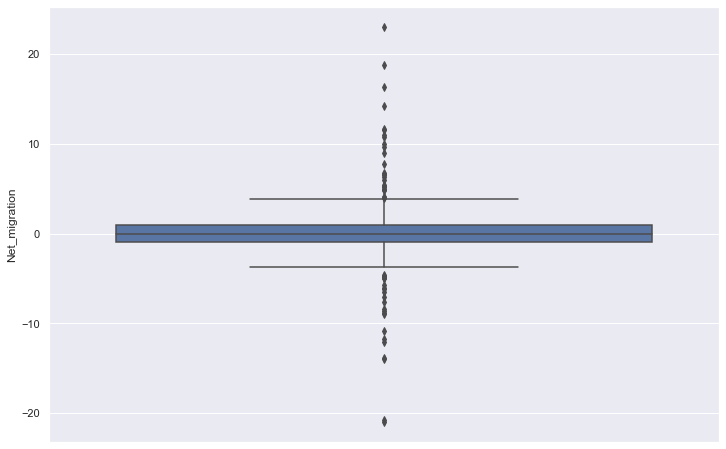

In [33]:
sns.boxplot(countries['Net_migration'], orient='vertical')


In [34]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 0 to 195
Data columns (total 20 columns):
Country             227 non-null object
Region              227 non-null object
Population          227 non-null int64
Area                227 non-null int64
Pop_density         227 non-null float64
Coastline_ratio     227 non-null float64
Net_migration       224 non-null float64
Infant_mortality    224 non-null float64
GDP                 226 non-null float64
Literacy            209 non-null float64
Phones_per_1000     223 non-null float64
Arable              225 non-null float64
Crops               225 non-null float64
Other               225 non-null float64
Climate             205 non-null float64
Birthrate           224 non-null float64
Deathrate           223 non-null float64
Agriculture         212 non-null float64
Industry            211 non-null float64
Service             212 non-null float64
dtypes: float64(16), int64(2), object(2)
memory usage: 37.2+ KB


In [35]:
q1_quantile = countries['Net_migration'].quantile(0.25)
q3_quantile = countries['Net_migration'].quantile(0.75)
iqr = q3_quantile - q1_quantile

non_outlier_interval_iqr = [q1_quantile - 1.5 * iqr, q3_quantile + 1.5 * iqr]

#print(f"Faixa considerada \"normal\": {non_outlier_interval_iqr}")

In [36]:
#calculo para achar os que estão fora da faixa normal
outliers_iqr_lower = countries['Net_migration'][countries['Net_migration'] < non_outlier_interval_iqr[0]]  
outliers_iqr_higher = countries['Net_migration'][countries['Net_migration'] > non_outlier_interval_iqr[1]]
qtd_outliers = len(outliers_iqr_lower)+len(outliers_iqr_higher)
#qtd_outliers


In [37]:
qtd_dados = countries.shape[0]
#qtd_dados

In [38]:
print('Porcentagem de outliers: {}'.format((qtd_outliers*100)/qtd_dados))

Porcentagem de outliers: 22.026431718061673


In [39]:
def q5():
    #Como temos 22% de outliers, precisaria de melhor analise para decidir como tratar, pois pode ter perda de informação.
    return (outliers_iqr_lower.shape[0], outliers_iqr_higher.shape[0], False)


In [40]:
q5()

(24, 26, False)

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [41]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)


In [42]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(newsgroup.data)

In [43]:
df_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df_words['phone'].sum()

213

In [44]:
def q6():
    df_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    return int(df_words['phone'].sum())
    # Retorne aqui o resultado da questão 4.

In [45]:
q6()

213

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [46]:
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X)

newsgroups_tfidf = tfidf_transformer.transform(X)

In [47]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

newsgroups_tfidf_vectorized=tfidf_vectorizer.fit_transform(newsgroup.data)
newsgroups_tfidf_vectorized

<1773x27335 sparse matrix of type '<class 'numpy.float64'>'
	with 227238 stored elements in Compressed Sparse Row format>

In [48]:
words_idx = sorted([vectorizer.vocabulary_.get('phone')])
df_phone = pd.DataFrame(newsgroups_tfidf[:, words_idx].toarray(), columns=np.array(vectorizer.get_feature_names())[words_idx])
df_phone['phone'].sum()




8.88774594667355

In [49]:
def q7():
    return float(round(df_phone.sum(),3))

    # Retorne aqui o resultado da questão 4.


In [50]:
q7()

8.888